# SIM Contrast Measurment

In [1]:
# get our environment ready for data analysis times
%pylab inline

# import some os functionality so that we can be platform independent
import os
import re

# import skimage components
from skimage.external import tifffile as tif

# pretty plots
import seaborn as sns

# import analysis code
from peaks.stackanalysis import scatterplot, SIMStackAnalyzer

# 
from matplotlib.colors import ColorConverter

Populating the interactive namespace from numpy and matplotlib


In [2]:
# size of the fitting window, should be more than 6 sigma of PSF
window_width = 10
phases = 15
print("Loading Data ... ", end="")
# load data into analyzer
%time v = SIMStackAnalyzer(tif.imread("../fixtures/SIM Beads.tif"), 5, phases, 1.4, 1)
print("finding peaks ... ", end = "")
%time num_blobs = len(v.peakfinder.find_blobs())
print(num_blobs, " ", end = "")
print("pruning peaks ... ", end = "")
%time num_blobs = len(v.peakfinder.prune_blobs(window_width))
print(num_blobs, " ", end = "")
# filter saturated blobs
v.peakfinder.blobs = v.peakfinder.blobs[v.peakfinder.blobs[:,3] < 5e4]
print("fitting ... ", end = "")
# fit with 16 cores
%time v.fitPeaks(window_width, 8, quiet=True)
print("Calc SIM Params ... ", end = "")
%time v.calc_sim_params(8)

Loading Data ... Wall time: 653 ms
finding peaks ... Wall time: 78.1 ms
856  pruning peaks ... Wall time: 1.5 ms
604  fitting ... Multiprocessing engaged with 8 cores
Wall time: 22 s
Calc SIM Params ... Multiprocessing engaged with 8 cores
Wall time: 3.62 s


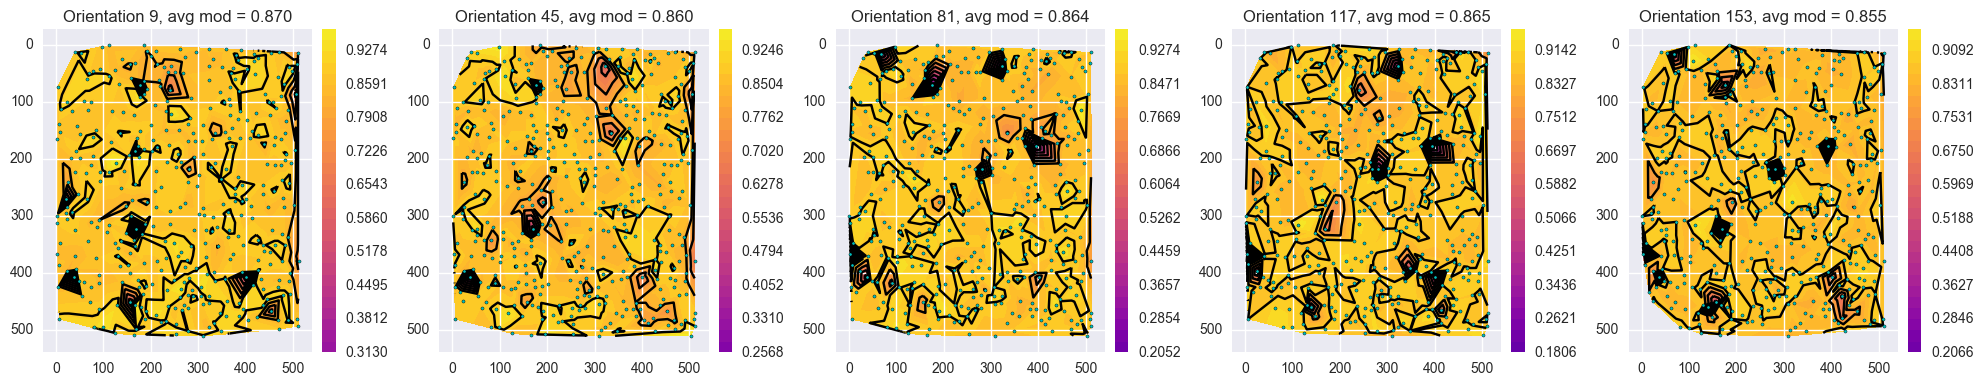

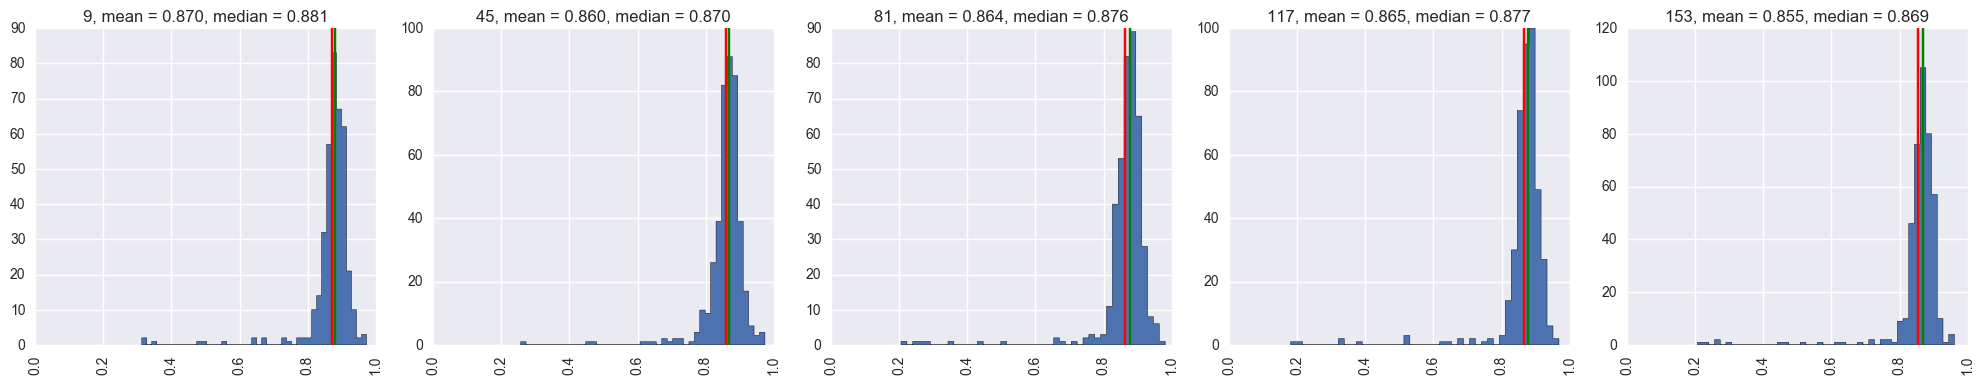

In [3]:
# filtering
# make sure we have resonable SNR
v.sim_params = v.sim_params[v.sim_params.SNR > 10]
v.sim_params = v.sim_params[v.sim_params.sin_SNR > 10]
# make sure mod amp is between 0 and 1
v.sim_params = v.sim_params[np.logical_and(v.sim_params.modulation <= 1.0,
                                           v.sim_params.modulation >= 0.0)]
# make sure fitted sigma is reasonable (discard clumps)
v.sim_params = v.sim_params[abs(v.sim_params.sigma_x) < 1.6]
v.sim_params = v.sim_params[abs(v.sim_params.sigma_y) < 1.6]
v.sim_params = v.sim_params[abs(v.sim_params.sigma_x) > 1.0]
v.sim_params = v.sim_params[abs(v.sim_params.sigma_y) > 1.0]
# make sure fitted frequency is resonable
v.sim_params = v.sim_params[abs(abs(v.sim_params.freq) - 1/phases) < 0.01]
# plot
fig, ax = v.plot_sim_params(['9','45','81', '117', '153'], method='linear', vmin=0, vmax=1)
# make and save histograms
fig, axs = v.plot_sim_hist(['9','45','81', '117', '153'])
fig.tight_layout()

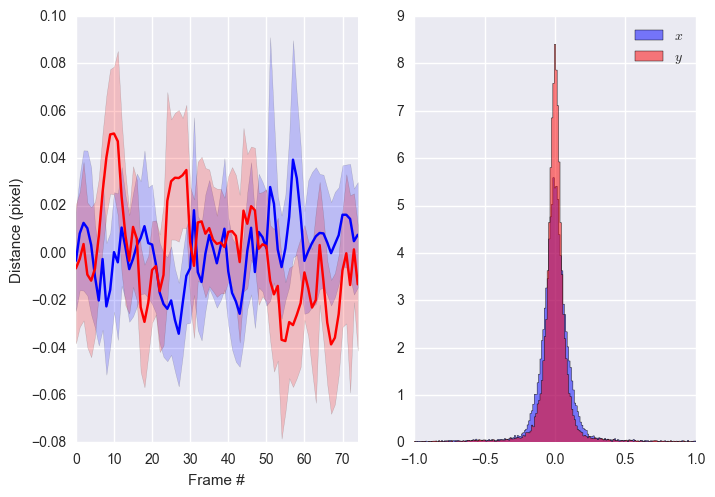

In [4]:
# set up plot for drift
fig, (ax0, ax1) = subplots(1, 2)
# make empty lists for x and y positions
x = []
y = []
# iterate through the fits
for f in v.fits:
    # make sure they're finite
    if isfinite(f.x0).all():
        # remove mean and append to list
        x.append(f.x0 - f.x0.mean())
        y.append(f.y0 - f.y0.mean())
# make the plots
sns.tsplot(x, ax= ax0, ci=90, color='b')
sns.tsplot(y, ax= ax0, ci=90, color='r')
ax0.set_xlabel('Frame #')
ax0.set_ylabel('Distance (pixel)')
xar = array(x).ravel()
yar = array(y).ravel()
nbins = int(sqrt(xar.size))
ax1.hist(xar, color=ColorConverter().to_rgba("b", 0.5), normed=True, label="$x$",
         bins=nbins,histtype="stepfilled", range=(-1, 1))
ax1.hist(yar, color=ColorConverter().to_rgba("r", 0.5), normed=True, label="$y$",
         bins=nbins,histtype="stepfilled", range=(-1, 1))
ax1.legend()